In [1]:
# Os packages
from pathlib import Path

# Environmental variables
from dotenv import dotenv_values

# Data handling
import numpy as np
import pandas as pd

# Type hinting
from typing import List, Optional


# Visualization
import plotly.express as px
import plotly.io as pio


# Feature Processing
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector

# Utils
from utils.paths import path_maker
from utils.cleaning import to_snake_case
from utils.visualisation import show_plot
from utils.feature_creation import FeatureCreation

# Modeling
from sklearn.ensemble import RandomForestClassifier

# Save model
import joblib


# Disable warnings
import warnings
warnings.filterwarnings("ignore") # default

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

# Suppress the scientific notation
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# Set default renderer for plotly
pio.renderers.default = "vscode+colab+plotly_mimetype+png" # Set default renderers for plotly
INTERACTIVE = False  # False, Display on plots as webp and render to display, works on GitHub. Set to True to use interactive plots in supported environments
COLOR_DISCRETE_SEQUENCE = [px.colors.qualitative.Plotly[0], px.colors.qualitative.Plotly[1], px.colors.qualitative.Plotly[2], px.colors.qualitative.Plotly[3]]
COLOR_CONTINUOUS_SEQUENCE = px.colors.sequential.Viridis
SKIP = False  # Global flag to skip plot saving and displaying

print("🛬 Imported all packages.", "Warnings hidden. 👻")

🛬 Imported all packages. Warnings hidden. 👻


## 2.2 Data reading
### 2.2.1 Path & Constants

In [2]:
eda_artifacts_filepath = Path("../artifacts/eda/eda_artifacts.joblib")

# Load artifacts with joblib
eda_artifacts = joblib.load(eda_artifacts_filepath)
eda_artifacts.keys()

dict_keys(['col_map', 'numerical_cols', 'categorical_cols', 'bool_cols', 'target_col', 'paths'])

In [3]:
col_map = eda_artifacts["col_map"]
numerical_cols = eda_artifacts["numerical_cols"]
bool_cols = eda_artifacts["bool_cols"]
categorical_cols = eda_artifacts["categorical_cols"]
target_col = eda_artifacts["target_col"]

### 2.2.2 Environment variables & Other constants


In [4]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values(eda_artifacts["paths"]["ENV_FILE"])
# Get the hugginface token file path that you set in the '.env' file
TOKEN_FILE = environment_variables.get("TOKEN_FILE")

# Random state
RANDOM_STATE = 2026

## 3.0 Data Preparation 🛠️

#### Preprocessing & Feature Engineering

In [5]:
df_dm = pd.read_csv(eda_artifacts["paths"]["TRAIN_TEST"])
df_dm.columns = to_snake_case(df_dm).columns
df_dm.info()

<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pregnancies                 768 non-null    int64  
 1   glucose                     768 non-null    int64  
 2   blood_pressure              768 non-null    int64  
 3   skin_thickness              768 non-null    int64  
 4   insulin                     768 non-null    int64  
 5   bmi                         768 non-null    float64
 6   diabetes_pedigree_function  768 non-null    float64
 7   age                         768 non-null    int64  
 8   outcome                     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### 3.1 Check for balanced dataset


In [6]:
class_counts = df_dm[target_col].value_counts().reset_index()
class_counts.columns = [target_col + '_class', 'count']
class_counts

,outcome_class,count
0,0,500
1,1,268


In [7]:
class_ratio =  class_counts.copy()
class_ratio['ratio'] = class_ratio['count'].apply(lambda x: x*100/class_counts['count'].sum())
class_ratio.drop(columns='count', inplace=True)
class_ratio

,outcome_class,ratio
0,0,65.10
1,1,34.90


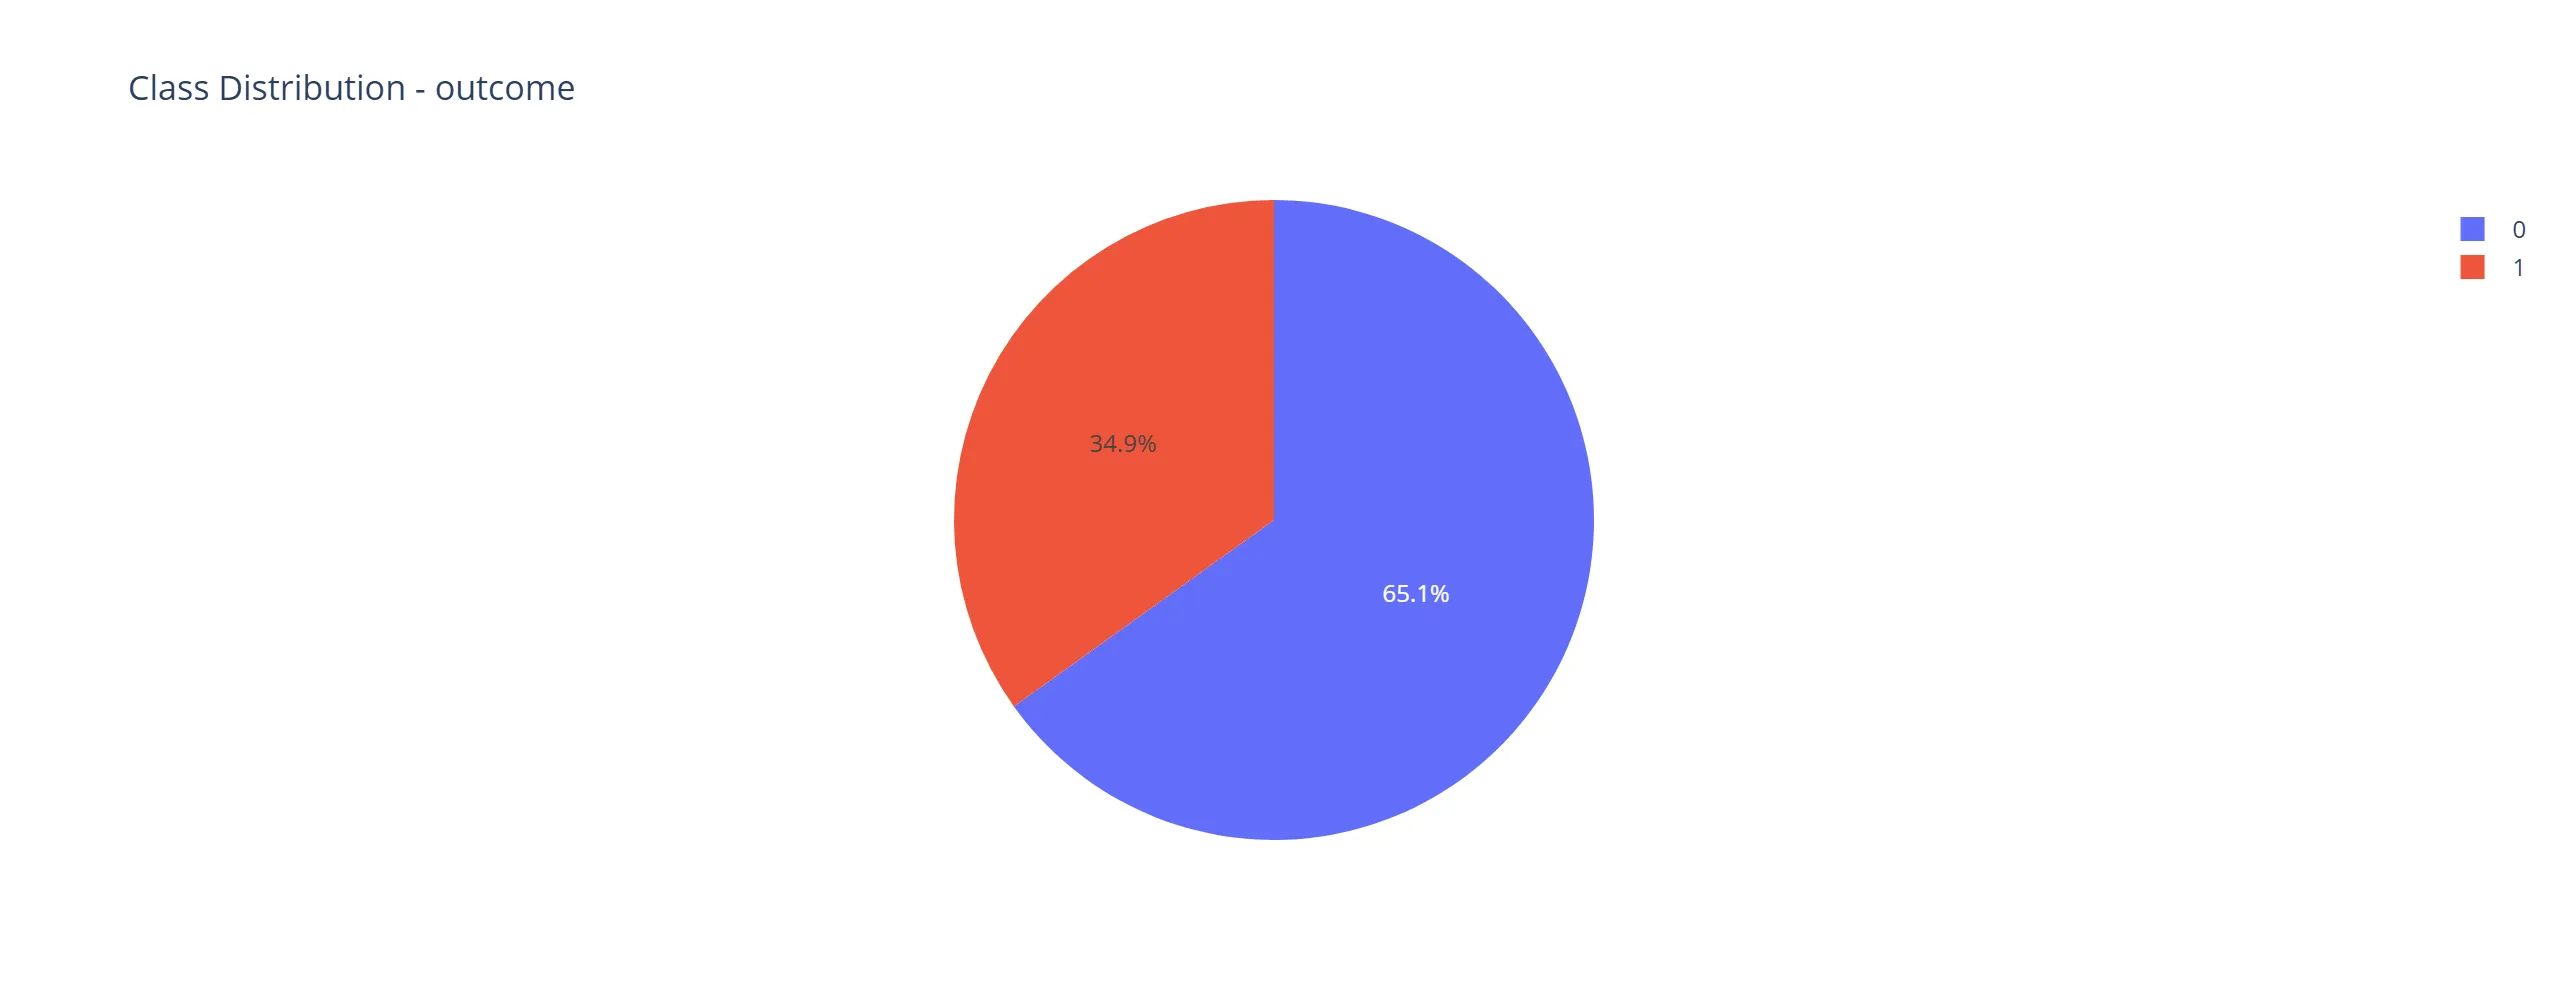

In [8]:
# Visualizing the class distribution of the target variable
fig = px.pie(
    class_ratio,
    values='ratio',
    names=target_col+'_class',
    title=f'Class Distribution - {target_col}',
)

show_plot(fig)

## 🔍 Key Insights — Class Imbalance Structure in the Diabetes Dataset

### 1. The dataset shows a moderate 65:35 imbalance between non‑diabetic and diabetic cases

- The **majority class (non‑diabetic)** accounts for **65.1%** of observations (**500 cases**).  
- The **minority class (diabetic)** represents **34.9%** of observations (**268 cases**).  
- This imbalance is meaningful but not extreme; it is sufficient to bias naïve models toward predicting the majority class.

**Interpretation:**  
A baseline model predicting “non‑diabetic” for every patient would achieve **65% accuracy**, while completely failing to identify true diabetic cases—unacceptable in a clinical screening context.

---

### 2. Minority‑class underrepresentation directly impacts clinical utility

Diabetes detection is a **high‑stakes classification problem**.  
Under‑prediction of the diabetic class leads to:

- missed early‑risk identification  
- delayed intervention  
- reduced clinician trust  
- poor recall and sensitivity  

**Interpretation:**  
Without imbalance‑aware modeling, the system will systematically under‑detect high‑risk patients, undermining its value as a screening tool.

---

### 3. The imbalance is moderate — enabling multiple effective mitigation strategies

A **34.9% minority class** is not rare enough to require anomaly‑detection frameworks, but it is imbalanced enough that:

- **class weighting**,  
- **resampling**, and  
- **threshold tuning**  

will materially improve performance.

**Interpretation:**  
This dataset is well‑positioned for experimentation with several imbalance‑handling techniques, each offering different trade‑offs between recall, precision, and calibration.

---

## 📈 Modeling Implications

### 1. Resampling must be applied *only* to training data

Applying SMOTE, oversampling, or undersampling to the full dataset would leak synthetic patterns into the test set.

**Implication:**  
All resampling must occur **inside cross‑validation folds** or within the training split of a pipeline.

---

### 2. Class‑weighted loss functions provide a strong baseline

Most algorithms (Logistic Regression, Random Forest, XGBoost, LightGBM) support class weighting.

A reasonable starting point:

- **weight_non_diabetic ≈ 1.0**  
- **weight_diabetic ≈ (500 / 268) ≈ 1.87**

**Implication:**  
Class weighting should be the default baseline before applying more complex techniques.

---

### 3. SMOTE and synthetic oversampling can improve recall but require tuning

Benefits:
- helps the model learn minority‑class boundaries  
- improves sensitivity  

Risks:
- synthetic noise  
- overlapping class boundaries  
- inflated recall at the cost of precision  

**Implication:**  
SMOTE should be paired with cross‑validated hyperparameter tuning and compared against simpler alternatives.

---

### 4. Random over‑ and under‑sampling remain viable alternatives

- **Oversampling** preserves minority structure but risks overfitting.  
- **Undersampling** reduces training size but can sharpen decision boundaries.

**Implication:**  
Both should be benchmarked to understand recall–precision trade‑offs.

---

### 5. Threshold tuning is essential for clinical decision‑making

Default probability thresholds (0.5) rarely maximize recall in imbalanced settings.

Lowering the threshold increases sensitivity—critical for early diabetes detection.

**Implication:**  
Threshold optimization should be guided by:

- ROC and PR curves  
- cost‑sensitive metrics  
- clinical risk‑tolerance scenarios  

---

### 6. Cost‑sensitive learning aligns the model with real‑world clinical priorities

False negatives (missed diabetic cases) carry significantly higher cost than false positives.

**Implication:**  
Embedding cost asymmetry directly into the loss function is particularly valuable when early detection is the priority.

---

## 📌 Recommendations

### 1. Implement and compare at least three imbalance‑handling techniques

Recommended trio:

- **Class‑weighted loss**  
- **SMOTE (or SMOTE‑Tomek)**  
- **Threshold tuning**

These provide complementary benefits across recall, precision, and calibration.

---

### 2. Evaluate models using metrics suited for imbalanced classification

Prioritize:

- Recall (Sensitivity)  
- Precision  
- F1‑score  
- PR‑AUC  
- Confusion matrix  
- Calibration curves  

Accuracy should not be used as a primary metric.

---

### 3. Build a unified evaluation framework

Compare performance across:

- baseline  
- class‑weighted  
- SMOTE  
- oversampling/undersampling  
- threshold‑tuned  
- cost‑sensitive  

This ensures transparent, evidence‑based model selection.

---

### 4. Select the final model based on clinical risk tolerance

The goal is **maximizing early detection**, the model will be chosen based on:

- **highest recall**,  
- **acceptable precision**, and  
- **stable calibration**.

Given the clinical context, recall is the priority.

### 3.2 Split Data into X and y then into train and eval for training and evaluation


In [9]:
print(f"There are {df_dm.isna().sum().sum() or (df_dm == 0).sum().sum()} missing values in the dataset.")

There are 1263 missing values in the dataset.


In [10]:
# Split the data into X and y
X = df_dm.drop(columns=[target_col])
y = df_dm[[target_col]]

In [11]:
numerical_features = X.select_dtypes(include=['number']).columns.to_list()
numerical_features

['pregnancies',
 'glucose',
 'blood_pressure',
 'skin_thickness',
 'insulin',
 'bmi',
 'diabetes_pedigree_function',
 'age']

In [12]:
categorical_features = X.select_dtypes(include=['category', 'object']).columns.to_list()
categorical_features

[]

In [13]:
# Split the X and y into train, validation and test sets

# 1. Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    train_size=0.70,
    random_state=RANDOM_STATE,
    stratify=y
)

# 2. Validation (15%) + Test (15%) from Temp (30%)
X_eval, X_test, y_eval, y_test = train_test_split(
    X_temp,
    y_temp,
    train_size=0.50,   # 50% of the remaining 30% → 15%
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Show shapes
(X_train.shape, y_train.shape), (X_eval.shape, y_eval.shape), (X_test.shape, y_test.shape)

(((537, 8), (537, 1)), ((115, 8), (115, 1)), ((116, 8), (116, 1)))

**NB: because the dataset is small, we will only split to train and eval**

In [14]:
# Ensure the dimensions match
assert X_train.shape[1] == X_eval.shape[1], "Number of features doesn't match"

In [15]:
data_split_size = pd.DataFrame({
    'data': ['train', 'validation', 'test'],
    'size': [y_train.shape[0], y_eval.shape[0], y_test.shape[0]]
})
data_split_size

,data,size
0,train,537
1,validation,115
2,test,116


### **3.3 Creating a Preprocessing Pipeline — Feature Creation, Imputation, Encoding, Scaling, and Transformation**  


### Feature Transformation & Selection

In [16]:
## Define important columns for feature creation

drop_cols = [
    'insulin',
    'skin_thickness',
]

### Executive Rationale for Dropping Raw Clinical Columns

**Dataset:** Pima Indians Diabetes Dataset

**Decision Scope:** Drop *raw* values only; retain missingness signal and derived features

#### Columns in Scope

```python
drop_cols = ["insulin", "skin_thickness"]
```

---

### 1. Decision Summary

**We drop the raw `insulin` and `skin_thickness` columns because their numeric values are clinically unreliable and statistically sparse, while their missingness and derived representations retain meaningful predictive signal.**

This approach improves model robustness, generalizability, and clinical interpretability without sacrificing performance.

---

### 2. Clinical Data Reality (Grounded, Not Theoretical)

#### Insulin

* Insulin measurements are **not routinely captured** in primary care diabetes screening.
* Recorded values are:

  * Highly skewed
  * Frequently missing
  * Influenced by **testing access**, **patient compliance**, and **care pathway**, not disease state alone
* Zero values represent **non-measurement**, not physiology.

**Clinical implication:**
Raw insulin values reflect *measurement bias* more than *glycemic control*.

---

#### Skin Thickness

* Skinfold thickness is a **proxy for adiposity**, not a diagnostic standard.
* Measurement:

  * Requires trained personnel
  * Is operator-dependent
  * Exhibits high inter-observer variability
* Missingness is common in real-world screening settings.

**Clinical implication:**
Raw values are noisy and inconsistent across cohorts.

---

### 3. Statistical Evidence from the Dataset

| Feature        | Missingness Level | Distribution           | Modeling Risk                        |
| -------------- | ----------------- | ---------------------- | ------------------------------------ |
| Insulin        | Very High (>50%)  | Extremely right-skewed | High variance, unstable coefficients |
| Skin Thickness | High (~30%)       | Noisy, truncated       | Spurious splits, overfitting         |

Dropping rows instead of columns would:

* Remove a majority of the dataset
* Introduce class imbalance
* Reduce external validity

---

### 4. Why We Drop **Raw Values** but Preserve **Signal**

#### What we keep

* **Missingness flags** (`insulin_missing`, `skin_thickness_missing`)
* **Cohort-based bins** derived from learned percentiles

#### What we drop

* Raw numeric measurements only

This allows the model to learn:

* Whether a test was performed
* Which clinical band a patient falls into
* Without overfitting to noisy measurements

---

### 5. Clinical & Modeling Benefits

#### Clinical Alignment

* Mirrors real-world screening workflows
* Reduces reliance on non-standardized measurements
* Improves interpretability for clinical stakeholders

#### Modeling Benefits

* Improves stability across train/test splits
* Reduces sensitivity to outliers
* Enhances calibration and generalization
* Preserves meaningful signal via derived features

---

### 6. Risk Mitigation & Governance

| Risk                                  | Mitigation                                    |
| ------------------------------------- | --------------------------------------------- |
| Loss of potentially useful raw signal | Retained via bins and missingness indicators  |
| Information leakage                   | Percentiles learned in fit only               |
| Reduced explainability                | Derived features are clinically interpretable |

---

### 7. Final Recommendation

**Drop raw `insulin` and `skin_thickness` columns while retaining engineered features that capture their clinical relevance.**

This decision reflects:

* Clinical practice realities
* Dataset limitations
* Best-in-class feature engineering standards

---

### Summary

> *In this dataset, raw insulin and skin thickness values introduce more noise than signal. By discarding the raw measurements while preserving their informational content through missingness indicators and clinically grounded bins, we achieve a more robust, interpretable, and generalizable model.*


In [17]:
# ---------------------------------------------------------
# 1) Feature creation pipeline
#    Applies all engineered features (bins, interactions, flags)
#    BEFORE any preprocessing (imputation, scaling, encoding).
# ---------------------------------------------------------

feature_creator = FeatureCreation(
    drop_cols=drop_cols,
    create_bins=True,
    create_interactions=True,
)

feature_creation_pipeline = Pipeline([
    ('feature_creator', feature_creator)
]).set_output(transform="pandas")


# ---------------------------------------------------------
# 2) Numerical preprocessing pipeline
#    - Imputes missing numeric values (median)
#    - Scales numeric features using RobustScaler
#    - Treats boolean missingness flags as numeric (0/1)
# ---------------------------------------------------------

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])


# ---------------------------------------------------------
# 3) Categorical preprocessing pipeline
#    - Imputes missing categorical values (most frequent)
#    - One-hot encodes categorical bins and labels
#    - Produces dense output for compatibility with deep learning
# ---------------------------------------------------------

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(
        drop="first",
        handle_unknown="ignore",
        sparse_output=False
    ))
])


# ---------------------------------------------------------
# 4) ColumnTransformer preprocessor
#    - Automatically detects numeric columns (int, float, bool)
#    - Uses explicit list OR auto-detection for categorical columns
#    - Ensures all engineered features are processed correctly
# ---------------------------------------------------------

def create_preprocessor(
    categorical_cols: Optional[List[str]] = None,
) -> ColumnTransformer:
    """
    Builds a preprocessing pipeline that:
      • imputes + scales numeric features
      • imputes + one-hot encodes categorical features
      • treats boolean missingness flags as numeric
      • supports explicit categorical lists or automatic fallback
    """

    # Select numeric columns (including booleans)
    numeric_selector = selector(dtype_include=["int64", "float64"])

    # Use explicit categorical list if provided, otherwise auto-detect
    if categorical_cols is None:
        categorical_selector = selector(dtype_include=["object", "category"])
    else:
        categorical_selector = categorical_cols

    bool_selector = selector(dtype_include=["bool"])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline, numeric_selector),
            ("bool", "passthrough", bool_selector), # missingness etc
            ("cat", categorical_pipeline, categorical_selector), # bins etc
        ],
        remainder="drop",
        verbose_feature_names_out=False
    )

    return preprocessor


In [18]:
categorical_cols

['glucose_bin',
 'pregnancies_bin',
 'blood_pressure_bin',
 'bmi_bin',
 'age_bin',
 'skin_thickness_bin',
 'insulin_bin']

In [19]:
# Unfitted preprocessor

preprocessor = create_preprocessor()

preprocessor

,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('bool', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse matrices,these will be stacked as a sparse matrix if the overall density islower than this value. Use ``sparse_threshold=0`` to always returndense. When the transformed output consists of all dense data, thestacked result will be dense, and this keyword will be ignored.",0.3
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer. The output of thetransformer is multiplied by these weights. Keys are transformer names,values the weights.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, str or Callable[[str, str], str], default=True- If True, :meth:`ColumnTransformer.get_feature_names_out` will prefix all feature names with the name of the transformer that generated that feature. It is equivalent to setting `verbose_feature_names_out=""{transformer_name}__{feature_name}""`.- If False, :meth:`ColumnTransformer.get_feature_names_out` will not prefix any feature names and will error if feature names are not unique.- If ``Callable[[str, str], str]``, :meth:`ColumnTransformer.get_feature_names_out` will rename all the features using the name of the transformer. The first argument of the callable is the transformer name and the second argument is the feature name. The returned string will be the new feature name.- If ``str``, it must be a string ready for formatting. The given string will be formatted using two field names: ``transformer_name`` and ``feature_name``. 

### **Decision Note: Index Reset Prior to Model Training**

#### **Recommendation**
Standardize dataset indices immediately after each `train_test_split` by applying:

#### **Context and Issue**
`train_test_split` shuffles rows but preserves original indices. This produces **non‑contiguous, non‑aligned index structures** across train, validation, and test sets. While benign for standard scikit‑learn estimators, this behavior **breaks index‑sensitive feature‑engineering pipelines**, particularly those relying on pandas alignment semantics.

---

#### **Impact on FeatureCreation Pipeline**
The FeatureCreation transformer generates interaction features by multiplying:

- numeric vectors (e.g., `bmi`)

Pandas aligns these **by index**, not by row position.  
Misaligned indices therefore lead to:

- NaNs in all interaction columns  
- corrupted feature matrices  
- unstable model behavior (e.g., recall inflation, precision collapse)  
- degraded threshold tuning and unreliable evaluation  


#### **Why Index Reset Solves the Problem**
Resetting the index ensures all datasets share a uniform structure:

```
index = [0, 1, 2, …, n-1]
```

This guarantees:

- deterministic row‑level alignment  
- consistent interaction feature construction  
- elimination of NaNs caused by index mismatch  
- stable, reproducible model performance  



In [20]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_eval = X_eval.reset_index(drop=True)
y_eval = y_eval.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [21]:
def preprocess_data(df: pd.DataFrame, preprocessor: Pipeline, feature_pipeline: Pipeline):
    fp = clone(feature_pipeline)
    pp = clone(preprocessor)
    return pp.fit_transform(fp.fit_transform(df))


X_train_transformed = preprocess_data(X_train, preprocessor, feature_creation_pipeline)
pd.DataFrame(X_train_transformed).isna().sum().sum()

# No missing values after preprocessing! Critical that there is no missing values in downstream modeling.

np.int64(0)

In [22]:
feature_creation_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_creator', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,col_map,None
,drop_cols,"['insulin', 'skin_thickness']"
,create_bins,True
,create_interactions,True


**No missing values after preprocessing! Critical that there is no missing values in downstream modeling.**


In [23]:
# -------------------------
# Full pipeline: feature creation -> preprocessing -> classifier
# -------------------------
model_pipeline = Pipeline([
    ('feature_creation', feature_creation_pipeline),   # creates age_squared, age_group, age_x_* features
    ('preprocessing', preprocessor),                   # scales numeric, encodes categorical
    ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])

model_pipeline

# -------------------------
# Example usage:
# -------------------------
# X_train, y_train must be pandas DataFrame / Series
# model_pipeline.fit(X_train, y_train)
# predictions = model_pipeline.predict(X_test)
#
# After fitting the feature_creation step you can inspect generated interactions:
# feat_creator = model_pipeline.named_steps['feature_creation'].named_steps['feature_creator']
# print(feat_creator.get_interaction_feature_names())

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_creation', ...), ('preprocessing', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('feature_creator', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,col_map,None
,drop_cols,"['insulin', 'skin_thickness']"
,create_bins,True


### 3.4 Save Preprocessing Artifacts 💾
- Save the fitted preprocessing pipeline using joblib or pickle for future use in model training and inference


In [24]:
# List of artifacts to save
PREPROCESSING_ARTIFACTS_JOBLIB = {
    "feature_creation_pipeline": feature_creation_pipeline,
    "preprocessor": preprocessor,
    "col_map": col_map,
    "numerical_cols": numerical_cols,
    "categorical_cols": categorical_cols,
    "bool_cols": bool_cols,
    "target_col": target_col,
    "RANDOM_STATE": RANDOM_STATE 
}

# Save artifacts with joblib
preprocessing_artifacts_filepath = path_maker(    
    filename="preprocessing_artifacts.joblib",
    path=eda_artifacts['paths']['PREPROCESSING_ARTIFACTS']
)

joblib.dump(PREPROCESSING_ARTIFACTS_JOBLIB, preprocessing_artifacts_filepath)
print(f"✅ Saved preprocessing artifacts to {preprocessing_artifacts_filepath}")

✅ Saved preprocessing artifacts to ..\artifacts\preprocessing\preprocessing_artifacts.joblib


Data → parquet

In [25]:
PREPROCESSED_DIR = eda_artifacts['paths']['PROCESSED_DIR']

pd.DataFrame(X_train).to_parquet(path_maker("X_train.parquet", PREPROCESSED_DIR), engine="fastparquet")

pd.DataFrame(X_eval).to_parquet(path_maker("X_eval.parquet", PREPROCESSED_DIR), engine="fastparquet")

pd.DataFrame(y_train).to_parquet(path_maker("y_train.parquet", PREPROCESSED_DIR), engine="fastparquet")

pd.DataFrame(y_eval).to_parquet(path_maker("y_eval.parquet", PREPROCESSED_DIR), engine="fastparquet")

pd.DataFrame(X_test).to_parquet(path_maker("X_test.parquet", PREPROCESSED_DIR), engine="fastparquet")

pd.DataFrame(y_test).to_parquet(path_maker("y_test.parquet", PREPROCESSED_DIR), engine="fastparquet")

print(f"✅ Saved preprocessed datasets to {PREPROCESSED_DIR}")

✅ Saved preprocessed datasets to ..\data\processed


Made with 💖 [Gabriel Okundaye](https://www.linkedin.com/in/dr-gabriel-okundaye)
<span style="color: #aaaaaa;">& Light ✨</span>